# Reframing Design Pattern

In [308]:
import numpy as np
import seaborn as sns
from google.cloud import bigquery

import matplotlib as plt
%matplotlib inline

In [309]:
bq = bigquery.Client()

In [310]:
query = """
SELECT
  weight_pounds,
  is_male,
  gestation_weeks,
  mother_age,
  plurality,
  mother_race
FROM
  `bigquery-public-data.samples.natality`
WHERE
  weight_pounds IS NOT NULL
  AND is_male = true
  AND gestation_weeks = 38
  AND mother_age = 28
  AND mother_race = 1
  AND plurality = 1
  AND RAND() < 0.01
"""

In [311]:
df = bq.query(query).to_dataframe()
df.head()

,weight_pounds,is_male,gestation_weeks,mother_age,plurality,mother_race
0,8.183559,True,38,28,1,1
1,6.702053,True,38,28,1,1
2,6.686620,True,38,28,1,1
3,6.124442,True,38,28,1,1
4,8.333474,True,38,28,1,1


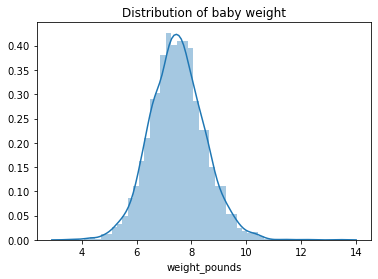

In [312]:
fig = sns.distplot(df[["weight_pounds"]])
fig.set_title("Distribution of baby weight")
fig.set_xlabel("weight_pounds")
fig.figure.savefig("weight_distrib.png")

In [313]:
#average weight_pounds for this cross section
np.mean(df.weight_pounds)

7.488892435946641

## Create categorical label

In [314]:
import os

import pandas as pd
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models, Model

In [315]:
df = pd.read_csv("./data/babyweight_train.csv")

In [355]:
def categorical_weight(weight_pounds):
    if weight_pounds < 3.31:
        return 0
    elif weight_pounds >= 3.31 and weight_pounds < 5.5:
        return 1
    elif weight_pounds >= 5.5 and weight_pounds < 8.8:
        return 2
    else:
        return 3

In [356]:
df["weight_category"] = df.weight_pounds.apply(lambda x: categorical_weight(x))

In [357]:
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_race,weight_category
0,7.749249,False,12,Single(1),40,1.0,2
1,7.561856,True,12,Single(1),40,2.0,2
2,7.187070,False,12,Single(1),34,3.0,2
3,6.375769,True,12,Single(1),36,2.0,2
4,7.936641,False,12,Single(1),35,NaN,2


In [320]:
df.to_csv("./data/babyweight_categorical.csv", index=False)

In [346]:
# Determine CSV, label, and key columns
# Create list of string column headers, make sure order matches.
CSV_COLUMNS = ["is_male",
               "mother_age",
               "plurality",
               "gestation_weeks",
               "mother_race",
               "weight_category"
              ]

# Add string name for label column
LABEL_COLUMN = "weight_category"

# Set default values for each CSV column as a list of lists.
# Treat is_male and plurality as strings.
DEFAULTS = [["null"], [0.0], ["null"], [0.0], ["0"], [0]]

In [347]:
def get_dataset(file_path):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=15, # Artificially small to make examples easier to show.
        label_name=LABEL_COLUMN,
        select_columns=CSV_COLUMNS,
        column_defaults=DEFAULTS,
        num_epochs=1,
        ignore_errors=True)
    return dataset

train_data = get_dataset("./data/babyweight_categorical.csv")

In [348]:
def show_batch(dataset):
    for batch, label in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key,value.numpy()))
        print("label: {}".format(label))
show_batch(train_data)

is_male             : [b'True' b'True' b'False' b'False' b'True' b'False' b'True' b'True'
 b'True' b'False' b'False' b'False' b'True' b'False' b'True']
mother_age          : [15. 16. 17. 16. 15. 16. 18. 18. 15. 16. 14. 17. 17. 16. 17.]
plurality           : [b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)'
 b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)'
 b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)']
gestation_weeks     : [40. 40. 39. 40. 42. 38. 41. 39. 40. 35. 40. 40. 38. 40. 40.]
mother_race         : [b'1.0' b'1.0' b'0' b'1.0' b'1.0' b'0' b'2.0' b'2.0' b'1.0' b'1.0' b'1.0'
 b'2.0' b'0' b'1.0' b'0']
label: [2 2 2 2 2 2 2 2 2 1 2 2 2 2 2]


In [358]:
CATEGORIES = ['plurality', 'is_male', 'mother_race']

for feature in CATEGORIES:
    df[feature] = pd.Categorical(df[feature])
    df[feature] = df[feature].cat.codes

In [359]:
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_race,weight_category
0,7.749249,0,12,1,40,0,2
1,7.561856,1,12,1,40,1,2
2,7.187070,0,12,1,34,2,2
3,6.375769,1,12,1,36,1,2
4,7.936641,0,12,1,35,-1,2


In [364]:
dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train))

In [365]:
train_dataset = dataset.shuffle(len(df)).batch(1)

In [366]:
for feat, targ in train_dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [[ 0 16  1 39  0]], Target: [[0. 0. 1. 0.]]
Features: [[ 1 15  1 39  0]], Target: [[0. 0. 1. 0.]]
Features: [[ 1 16  1 39 -1]], Target: [[0. 0. 1. 0.]]
Features: [[ 1 16  1 36  0]], Target: [[0. 0. 1. 0.]]
Features: [[ 1 16  1 36 -1]], Target: [[0. 0. 1. 0.]]


In [379]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [380]:
model.fit(train_dataset, epochs=2)

Train for 3182 steps
Epoch 1/2
3182/3182 [==============================] - 10s 3ms/step - loss: 0.4798 - accuracy: 0.8721
Epoch 2/2
3182/3182 [==============================] - 10s 3ms/step - loss: 0.4386 - accuracy: 0.8831


In [394]:
preds = model.predict([[1, 38,  28, 1,  1]]).squeeze()
preds

array([4.2184001e-06, 7.3690456e-03, 9.7161555e-01, 2.1011246e-02],
      dtype=float32)

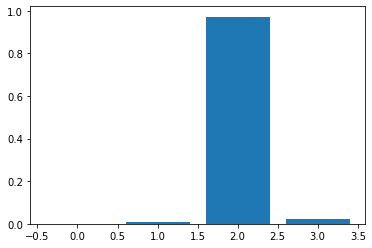

In [395]:
plt.bar(np.arange(len(preds)),preds)
plt.show()